In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import scipy.stats as stats
from scipy.stats import chi2
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import patsy

In [2]:
file_path = '/Users/mohanyang/Desktop/Shen Research/data/sleep_diary_all_updated.xlsx'
df = pd.read_excel(file_path, sheet_name='combined_psg_mood_all')


In [3]:
df.shape

(1077, 883)

In [4]:
df.describe()

,SID,AM_PM,Days,Visit,Sleep_Quality,SD_Q22.1,Pain_PMS,Bloating_PMS,Bodyache_PMS,Tenderness_PMS,...,N1,N2,SWS,NREM,REM,N1_TST,N2_TST,SWS_TST,NREM_TST,REM_TST
count,1077.000000,1077.0,1077.000000,893.000000,932.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,...,858.000000,858.000000,858.000000,858.00000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,298.141133,2.0,-0.102136,2.407615,4.715665,4.814299,0.803157,0.989786,0.846797,0.784587,...,13.681235,232.379371,89.143939,321.52331,90.250000,3.269329,54.103206,21.122908,75.226114,20.949234
std,247.944356,0.0,1.351292,1.095050,1.177871,1.161999,1.385087,1.362976,1.327337,1.389694,...,11.831941,56.232637,29.234137,61.82487,30.790852,2.838799,7.974129,6.624009,6.191531,5.647798
min,6.000000,2.0,-2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,25.500000,7.000000,59.00000,1.500000,0.000000,27.772326,1.707317,37.782139,0.465116
25%,42.000000,2.0,-1.000000,1.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,6.000000,203.000000,71.500000,295.12500,72.000000,1.542416,48.848170,17.435424,72.113290,17.869416
50%,505.000000,2.0,0.000000,2.000000,5.000000,5.000000,0.000000,1.000000,0.000000,0.000000,...,11.000000,231.000000,92.000000,322.50000,91.500000,2.674897,53.836317,21.636657,75.638051,21.281465
75%,531.000000,2.0,1.000000,3.000000,6.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,16.500000,259.375000,110.000000,353.00000,109.000000,3.655108,59.638554,25.079031,79.237845,24.699454
max,552.000000,2.0,2.000000,4.000000,7.000000,7.000000,6.000000,6.000000,6.000000,6.000000,...,83.500000,633.000000,172.000000,728.00000,189.500000,20.365854,73.629243,40.361446,88.315217,40.021119


In [5]:
# Treat the SD_questions, SID and Phase as categorical values
#SD_columns = [col for col in df.columns if col.startswith('SD_')]
#df[SD_columns] = df[SD_columns].astype('category')
df['SID'] = df['SID'].astype('category')
df['Phase'] = df['Phase'].astype('category')

In [6]:
df.head()

,SID,AM_PM,Days,Phase,Visit,Sleep_Quality,SD_Q22.1,Pain_PMS,Bloating_PMS,Bodyache_PMS,...,N1,N2,SWS,NREM,REM,N1_TST,N2_TST,SWS_TST,NREM_TST,REM_TST
0,6,2,-2,PO,1.0,4.0,4,0,0,0,...,6.5,175.0,117.5,292.5,64.0,1.790634,48.209366,32.369146,80.578512,17.630854
1,6,2,-1,PO,1.0,4.0,4,0,0,0,...,6.5,175.0,117.5,292.5,64.0,1.790634,48.209366,32.369146,80.578512,17.630854
2,6,2,0,PO,1.0,3.0,3,0,0,0,...,6.5,175.0,117.5,292.5,64.0,1.790634,48.209366,32.369146,80.578512,17.630854
3,6,2,1,PO,1.0,4.0,4,0,0,0,...,6.5,175.0,117.5,292.5,64.0,1.790634,48.209366,32.369146,80.578512,17.630854
4,6,2,2,PO,1.0,4.0,4,0,0,0,...,6.5,175.0,117.5,292.5,64.0,1.790634,48.209366,32.369146,80.578512,17.630854


In [7]:
print(df.dtypes)

SID         category
AM_PM          int64
Days           int64
Phase       category
Visit        float64
              ...   
N1_TST       float64
N2_TST       float64
SWS_TST      float64
NREM_TST     float64
REM_TST      float64
Length: 883, dtype: object


In [8]:
Mood_columns = [col for col in df.columns if col.endswith('Index')]
PMS_columns = [col for col in df.columns if col.endswith('PMS')]
Intake_columns = [col for col in df.columns if col.endswith('Intake')]
Hormone_columns = ["Mean_Est", "Mean_Prog", "Mean_Testost"]
Phase_terms = ["Phase[T.ML]", "Phase[T.MS]", "Phase[T.PO]", "Phase"]
additional_columns = [
    "Overall_Alertness", "Mental_Stamina", "Physical_Endurance", 
    "Physical_Strength", "Thinking", "Overall_Coordination", 
    "Mood_Stability", "Social_Interactions"
]


In [9]:
X = df[Mood_columns + PMS_columns + Intake_columns]
X = X.dropna(subset=Intake_columns)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

               feature       VIF
0  Positive_Mood_Index  2.049155
1  Negative_Mood_Index  3.488599
2      Anger_Fru_Index  3.132729
3             Pain_PMS  2.536932
4         Bloating_PMS  2.313230
5         Bodyache_PMS  2.840802
6       Tenderness_PMS  2.475736
7       Caffine_Intake  1.544659
8       Alcohol_Intake  1.062027


In [10]:
df_cleaned_for_mood = df.dropna(subset = Mood_columns + ["Phase", "REM", "SID"])
df_cleaned_for_mood_pms = df.dropna(subset=Mood_columns + PMS_columns + ["Phase", "REM", "SID"])
df_cleaned_for_mood_pms_intake = df.dropna(subset=Mood_columns + PMS_columns + Intake_columns + ["Phase", "REM", "SID"])

df_cleaned_for_REM = df.dropna(subset=Mood_columns + PMS_columns + Intake_columns 
                                      + Hormone_columns + additional_columns + ["Phase", "REM", "SID"])
df_cleaned_for_TST = df.dropna(subset=Mood_columns + PMS_columns + Intake_columns 
                                      + Hormone_columns + additional_columns + ["Phase", "TST", "SID"])
df_cleaned_for_WASO = df.dropna(subset=Mood_columns + PMS_columns + Intake_columns 
                                      + Hormone_columns + additional_columns + ["Phase", "WASO", "SID"])
df_cleaned_for_N1 = df.dropna(subset=Mood_columns + PMS_columns + Intake_columns 
                                      + Hormone_columns + additional_columns + ["Phase", "N1", "SID"])
df_cleaned_for_N2 = df.dropna(subset=Mood_columns + PMS_columns + Intake_columns 
                                      + Hormone_columns + additional_columns + ["Phase", "N2", "SID"])
df_cleaned_for_SWS = df.dropna(subset=Mood_columns + PMS_columns + Intake_columns 
                                      + Hormone_columns + additional_columns + ["Phase", "SWS", "SID"])
df_cleaned_for_NREM = df.dropna(subset=Mood_columns + PMS_columns + Intake_columns 
                                      + Hormone_columns + additional_columns + ["Phase", "NREM", "SID"])
print(df_cleaned_for_mood.shape)
print(df_cleaned_for_mood_pms.shape)
print(df_cleaned_for_mood_pms_intake.shape)
print(df_cleaned_for_REM.shape)
print(df_cleaned_for_TST.shape)
print(df_cleaned_for_WASO.shape)
print(df_cleaned_for_N1.shape)
print(df_cleaned_for_N2.shape)
print(df_cleaned_for_SWS.shape)
print(df_cleaned_for_NREM.shape)

(858, 883)
(858, 883)
(755, 883)
(455, 883)
(455, 883)
(367, 883)
(455, 883)
(455, 883)
(455, 883)
(455, 883)


In [11]:
formula1 = ("REM ~ " + 
           " + ".join(Mood_columns) + 
           " + Phase")

formula2 = ("REM ~ " + 
           " + ".join(Mood_columns) + 
           " + " + 
           " + ".join(PMS_columns) + 
           " + Phase")

formula3 = ("REM ~ " + 
           " + ".join(Mood_columns) + 
           " + " + 
           " + ".join(PMS_columns) + 
           " + " + 
           " + ".join(Intake_columns) +
           " + Phase")

print('formula1: ', formula1)
print('formula2: ', formula2)
print('formula3: ', formula3)

formula1:  REM ~ Positive_Mood_Index + Negative_Mood_Index + Anger_Fru_Index + Phase
formula2:  REM ~ Positive_Mood_Index + Negative_Mood_Index + Anger_Fru_Index + Pain_PMS + Bloating_PMS + Bodyache_PMS + Tenderness_PMS + Phase
formula3:  REM ~ Positive_Mood_Index + Negative_Mood_Index + Anger_Fru_Index + Pain_PMS + Bloating_PMS + Bodyache_PMS + Tenderness_PMS + Caffine_Intake + Alcohol_Intake + Phase


In [12]:
# Adding a random slope overfits the data, the random slope model is too complex and unnecessary.

"""model_with_phase_as_random_slope = smf.mixedlm(formula, df_cleaned, groups="SID", re_formula="~Phase")
result1 = model_with_phase_as_random_slope.fit(reml=False)
print(result1.summary())
print('AIC: ', result1.aic)
"""

'model_with_phase_as_random_slope = smf.mixedlm(formula, df_cleaned, groups="SID", re_formula="~Phase")\nresult1 = model_with_phase_as_random_slope.fit(reml=False)\nprint(result1.summary())\nprint(\'AIC: \', result1.aic)\n'

In [13]:
formula1_model_with_random_intercept = smf.mixedlm(formula1, df_cleaned_for_mood, groups = "SID")
result1 = formula1_model_with_random_intercept.fit(reml=False)
print(result1.summary())
print('AIC: ', result1.aic)

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   REM       
No. Observations:    858       Method:               ML        
No. Groups:          54        Scale:                391.3405  
Min. group size:     4         Log-Likelihood:       -3862.1450
Max. group size:     21        Converged:            Yes       
Mean group size:     15.9                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            89.905    4.221 21.298 0.000 81.631 98.179
Phase[T.ML]           1.568    1.956  0.801 0.423 -2.267  5.402
Phase[T.MS]           1.896    2.040  0.930 0.352 -2.101  5.894
Phase[T.PO]           1.741    2.004  0.868 0.385 -2.188  5.669
Positive_Mood_Index   0.592    0.712  0.831 0.406 -0.803  1.987
Negative_Mood_Index  -2.665    0.905 -2.944 0.003 -4.

In [14]:
formula2_model_with_random_intercept = smf.mixedlm(formula2, df_cleaned_for_mood_pms, groups = "SID")
result2 = formula2_model_with_random_intercept.fit(reml=False)
print(result2.summary())
print('AIC: ', result2.aic)

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   REM       
No. Observations:    858       Method:               ML        
No. Groups:          54        Scale:                388.8260  
Min. group size:     4         Log-Likelihood:       -3859.5025
Max. group size:     21        Converged:            Yes       
Mean group size:     15.9                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            89.789    4.234 21.205 0.000 81.490 98.088
Phase[T.ML]           1.451    1.956  0.742 0.458 -2.382  5.284
Phase[T.MS]           1.591    2.046  0.778 0.437 -2.418  5.601
Phase[T.PO]           1.700    2.004  0.848 0.396 -2.228  5.627
Positive_Mood_Index   0.496    0.721  0.688 0.492 -0.917  1.908
Negative_Mood_Index  -2.784    0.970 -2.870 0.004 -4.

In [15]:
formula3_model_with_random_intercept = smf.mixedlm(formula3, df_cleaned_for_mood_pms_intake, groups = "SID")
result3 = formula3_model_with_random_intercept.fit(reml=False)
print(result3.summary())
print('AIC: ', result3.aic)

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   REM       
No. Observations:    755       Method:               ML        
No. Groups:          53        Scale:                381.4692  
Min. group size:     2         Log-Likelihood:       -3397.1646
Max. group size:     21        Converged:            Yes       
Mean group size:     14.2                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            89.009    4.661 19.096 0.000 79.873 98.144
Phase[T.ML]           1.103    2.051  0.538 0.591 -2.916  5.122
Phase[T.MS]           1.672    2.223  0.752 0.452 -2.684  6.028
Phase[T.PO]          -1.018    2.187 -0.465 0.642 -5.305  3.269
Positive_Mood_Index   0.472    0.803  0.588 0.557 -1.102  2.046
Negative_Mood_Index  -2.686    1.107 -2.426 0.015 -4.

In [16]:
print('AIC for model 1: ', result1.aic)
print('AIC for model 2: ', result2.aic)
print('AIC for model 3: ', result3.aic)

AIC for model 1:  7742.290077812717
AIC for model 2:  7745.004988623763
AIC for model 3:  6824.329290455922


# Prepare plausible covariates and interaction terms to use

In [17]:
df_cleaned_for_mood_pms_intake = df_cleaned_for_mood_pms_intake.reset_index(drop = True)

dependent_vars = ["REM", "TST", "WASO", "N1", "N2", "SWS", "NREM"]
candidate_terms = Mood_columns + PMS_columns + Intake_columns + Hormone_columns + additional_columns + [
    "Phase"]


interaction_terms_with_phases = [f"Phase:{var}" for var in candidate_terms if var not in Hormone_columns]
interaction_terms_with_all_combo = [f"{var1}:{var2}" for var1, var2 in
                                    itertools.combinations(candidate_terms, 2)]

print("Candidate Terms: ", candidate_terms)
print("Interaction Terms with phases:", interaction_terms_with_phases)

Candidate Terms:  ['Positive_Mood_Index', 'Negative_Mood_Index', 'Anger_Fru_Index', 'Pain_PMS', 'Bloating_PMS', 'Bodyache_PMS', 'Tenderness_PMS', 'Caffine_Intake', 'Alcohol_Intake', 'Mean_Est', 'Mean_Prog', 'Mean_Testost', 'Overall_Alertness', 'Mental_Stamina', 'Physical_Endurance', 'Physical_Strength', 'Thinking', 'Overall_Coordination', 'Mood_Stability', 'Social_Interactions', 'Phase']
Interaction Terms with phases: ['Phase:Positive_Mood_Index', 'Phase:Negative_Mood_Index', 'Phase:Anger_Fru_Index', 'Phase:Pain_PMS', 'Phase:Bloating_PMS', 'Phase:Bodyache_PMS', 'Phase:Tenderness_PMS', 'Phase:Caffine_Intake', 'Phase:Alcohol_Intake', 'Phase:Overall_Alertness', 'Phase:Mental_Stamina', 'Phase:Physical_Endurance', 'Phase:Physical_Strength', 'Phase:Thinking', 'Phase:Overall_Coordination', 'Phase:Mood_Stability', 'Phase:Social_Interactions', 'Phase:Phase']


# Stepwise Algorithm

In [18]:
# Define function for stepwise selection using AIC
def backward_stepwise_selection(data, base_formula, candidate_terms, group_var):
    best_aic = float("inf")
    best_formula = f"{base_formula} + {' + '.join(candidate_terms)}"
    best_model = None
    current_terms = candidate_terms.copy()  # Start with all candidate terms
    model_count = 0

    while True:
        aic_results = []

        # Backward Elimination: Try removing each current term
        for term in current_terms:
            reduced_terms = [t for t in current_terms if t != term]
            formula = f"{base_formula} + {' + '.join(reduced_terms)}"
            try:
                model = smf.mixedlm(formula, data, groups=data[group_var])
                result = model.fit(reml=False)
                model_count += 1

                print(f"Backward step - Evaluating removal of term: {term}, AIC: {result.aic:.2f}")
                aic_results.append((result.aic, term, result))

            except Exception as e:
                print(f"Error fitting reduced model without term {term}: {e}")

        # Sort results by AIC
        aic_results.sort(key=lambda x: x[0])  # Sort by AIC (ascending)
        if not aic_results:
            break

        # Select the best term to remove
        best_candidate_aic, best_candidate_term, candidate_model = aic_results[0]

        # Update the model if AIC improves
        if best_candidate_aic < best_aic:
            best_aic = best_candidate_aic
            current_terms.remove(best_candidate_term)
            print(f"Removed term: {best_candidate_term}, Best AIC: {best_aic:.2f}")
            
            # Update the best model and formula
            best_model = candidate_model
            best_formula = f"{base_formula} + {' + '.join(current_terms)}"
        else:
            print(f"No improvement in AIC. Stopping backward stepwise selection.")
            break

    print(f"\nFinal Model Formula: {best_formula}")
    if best_model:
        print(f"\nFinal Model Summary:\n{best_model.summary()}")

    return best_model, model_count

In [19]:
def test_interaction_terms_lrt(base_model,base_formula,interaction_terms,data,group_var):
    lrt_results = []

    for interaction_term in interaction_terms:
        # Construct new formula by adding the interaction term
        new_formula = f"{base_formula} + {interaction_term}"
        
        try:
            new_model = smf.mixedlm(new_formula, data, groups=data[group_var]).fit(reml=False)

            lrt_stat = 2 * (new_model.llf - base_model.llf)
            df = new_model.df_modelwc - base_model.df_modelwc
            p_value = chi2.sf(lrt_stat, df)
            
            lrt_results.append({
                "Interaction Term": interaction_term,
                "LRT Statistic": lrt_stat,
                "Degrees of Freedom": df,
                "P-value": p_value,
                "AIC (New Model)": new_model.aic
            })
            
            print(f"Tested Interaction Term: {interaction_term}")
            print(f"LRT Statistic: {lrt_stat:.3f}, DF: {df}, P-value: {p_value:.3f}, AIC: {new_model.aic:.2f}")
        
        except Exception as e:
            # Handle fitting errors
            print(f"Error fitting model with interaction term {interaction_term}: {e}")
            lrt_results.append({
                "Interaction Term": interaction_term,
                "LRT Statistic": None,
                "Degrees of Freedom": None,
                "P-value": None,
                "AIC (New Model)": None
            })

    results_df = pd.DataFrame(lrt_results)
    return results_df

In [20]:
def plot_residual_diagnostics(fitted_values, residuals):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Residual Plot
    sns.scatterplot(x=fitted_values, y=residuals, ax=axes[0, 0])
    axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1)
    axes[0, 0].set_title('Residual Plot')
    axes[0, 0].set_xlabel('Fitted Values')
    axes[0, 0].set_ylabel('Residuals')

    # Histogram of Residuals
    sns.histplot(residuals, kde=True, bins=30, ax=axes[0, 1])
    axes[0, 1].set_title('Histogram of Residuals')
    axes[0, 1].set_xlabel('Residuals')
    axes[0, 1].set_ylabel('Frequency')

    # Scale-Location Plot
    sns.scatterplot(x=fitted_values, y=abs(residuals) ** 0.5, ax=axes[1, 0])
    axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=1)
    axes[1, 0].set_title('Scale-Location Plot')
    axes[1, 0].set_xlabel('Fitted Values')
    axes[1, 0].set_ylabel('$\sqrt{|Residuals|}$')

    # Q-Q Plot
    sm.qqplot(residuals, line='45', ax=axes[1, 1], fit=True)
    axes[1, 1].set_title('Q-Q Plot of Residuals')

    plt.tight_layout()
    plt.show()

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/var/folders/1n/n4qv89sn37l7_jng77dbmgfh0000gn/T/ipykernel_58364/2036997624.py:22: SyntaxWarning: invalid escape sequence '\s'
  axes[1, 0].set_ylabel('$\sqrt{|Residuals|}$')


## Model for REM

Backward step - Evaluating removal of term: Positive_Mood_Index, AIC: 4219.25
Backward step - Evaluating removal of term: Negative_Mood_Index, AIC: 4224.08
Backward step - Evaluating removal of term: Anger_Fru_Index, AIC: 4219.37
Backward step - Evaluating removal of term: Pain_PMS, AIC: 4218.99
Backward step - Evaluating removal of term: Bloating_PMS, AIC: 4219.11
Backward step - Evaluating removal of term: Bodyache_PMS, AIC: 4218.68
Backward step - Evaluating removal of term: Tenderness_PMS, AIC: 4217.91
Backward step - Evaluating removal of term: Caffine_Intake, AIC: 4218.22
Backward step - Evaluating removal of term: Alcohol_Intake, AIC: 4218.54
Backward step - Evaluating removal of term: Mean_Est, AIC: 4220.42
Backward step - Evaluating removal of term: Mean_Prog, AIC: 4220.52
Backward step - Evaluating removal of term: Mean_Testost, AIC: 4227.12
Backward step - Evaluating removal of term: Overall_Alertness, AIC: 4218.82
Backward step - Evaluating removal of term: Mental_Stamina, 

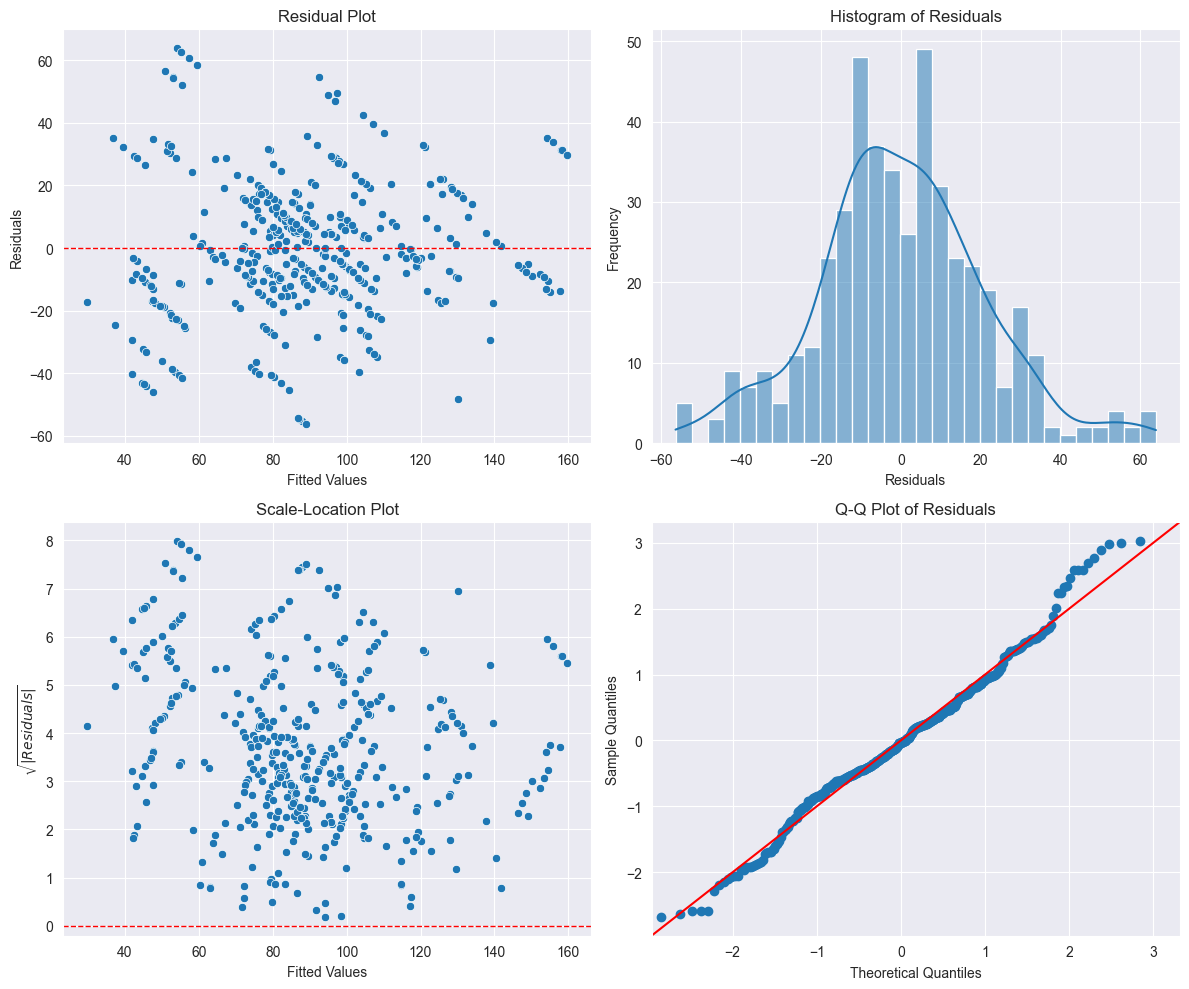

In [21]:
base_formula = "REM ~ 1"
test_terms = candidate_terms

best_model, model_count = backward_stepwise_selection(
    data=df_cleaned_for_REM,
    base_formula=base_formula,
    candidate_terms=test_terms,
    group_var="SID",
)

# Plot diagnostics for the best model
if best_model:
    plot_residual_diagnostics(best_model.fittedvalues, best_model.resid)

In [22]:
best_formula_no_interaction = best_model.model.formula
covariates = patsy.dmatrices(best_formula_no_interaction, df_cleaned_for_REM)[1].design_info.column_names
filtered_covariates = [var for var in covariates if var not in Hormone_columns and var not in Phase_terms]
interaction_terms_with_phases = [f"Phase:{var}" for var in filtered_covariates]

lrt_results_df = test_interaction_terms_lrt(
    base_model=best_model,  # The best model without interactions
    base_formula=best_formula_no_interaction,
    interaction_terms=interaction_terms_with_phases,
    data=df_cleaned_for_REM,
    group_var="SID"
)

# Sort by p-value to find significant interactions
lrt_results_df.sort_values(by="P-value", inplace=True)

print(lrt_results_df)

Error fitting model with interaction term Phase:Intercept: Error evaluating factor: NameError: name 'Intercept' is not defined
    REM ~ 1 + Negative_Mood_Index + Anger_Fru_Index + Mean_Testost + Mental_Stamina + Phase:Intercept
                                                                                            ^^^^^^^^^
Tested Interaction Term: Phase:Negative_Mood_Index
LRT Statistic: 2.470, DF: 3, P-value: 0.481, AIC: 4200.45
Tested Interaction Term: Phase:Anger_Fru_Index
LRT Statistic: 3.311, DF: 3, P-value: 0.346, AIC: 4199.61
Tested Interaction Term: Phase:Mental_Stamina
LRT Statistic: 0.556, DF: 3, P-value: 0.906, AIC: 4202.36
            Interaction Term  LRT Statistic  Degrees of Freedom   P-value  \
2      Phase:Anger_Fru_Index       3.310888                 3.0  0.346130   
1  Phase:Negative_Mood_Index       2.469668                 3.0  0.480798   
3       Phase:Mental_Stamina       0.556499                 3.0  0.906315   
0            Phase:Intercept            NaN

## Model for TST

Backward step - Evaluating removal of term: Positive_Mood_Index, AIC: 5108.15
Backward step - Evaluating removal of term: Negative_Mood_Index, AIC: 5107.97
Backward step - Evaluating removal of term: Anger_Fru_Index, AIC: 5107.90
Backward step - Evaluating removal of term: Pain_PMS, AIC: 5110.46
Backward step - Evaluating removal of term: Bloating_PMS, AIC: 5106.87
Backward step - Evaluating removal of term: Bodyache_PMS, AIC: 5108.24
Backward step - Evaluating removal of term: Tenderness_PMS, AIC: 5106.57
Backward step - Evaluating removal of term: Caffine_Intake, AIC: 5106.58
Backward step - Evaluating removal of term: Alcohol_Intake, AIC: 5106.74
Backward step - Evaluating removal of term: Mean_Est, AIC: 5116.26
Backward step - Evaluating removal of term: Mean_Prog, AIC: 5144.29
Backward step - Evaluating removal of term: Mean_Testost, AIC: 5129.24
Backward step - Evaluating removal of term: Overall_Alertness, AIC: 5108.94
Backward step - Evaluating removal of term: Mental_Stamina, 

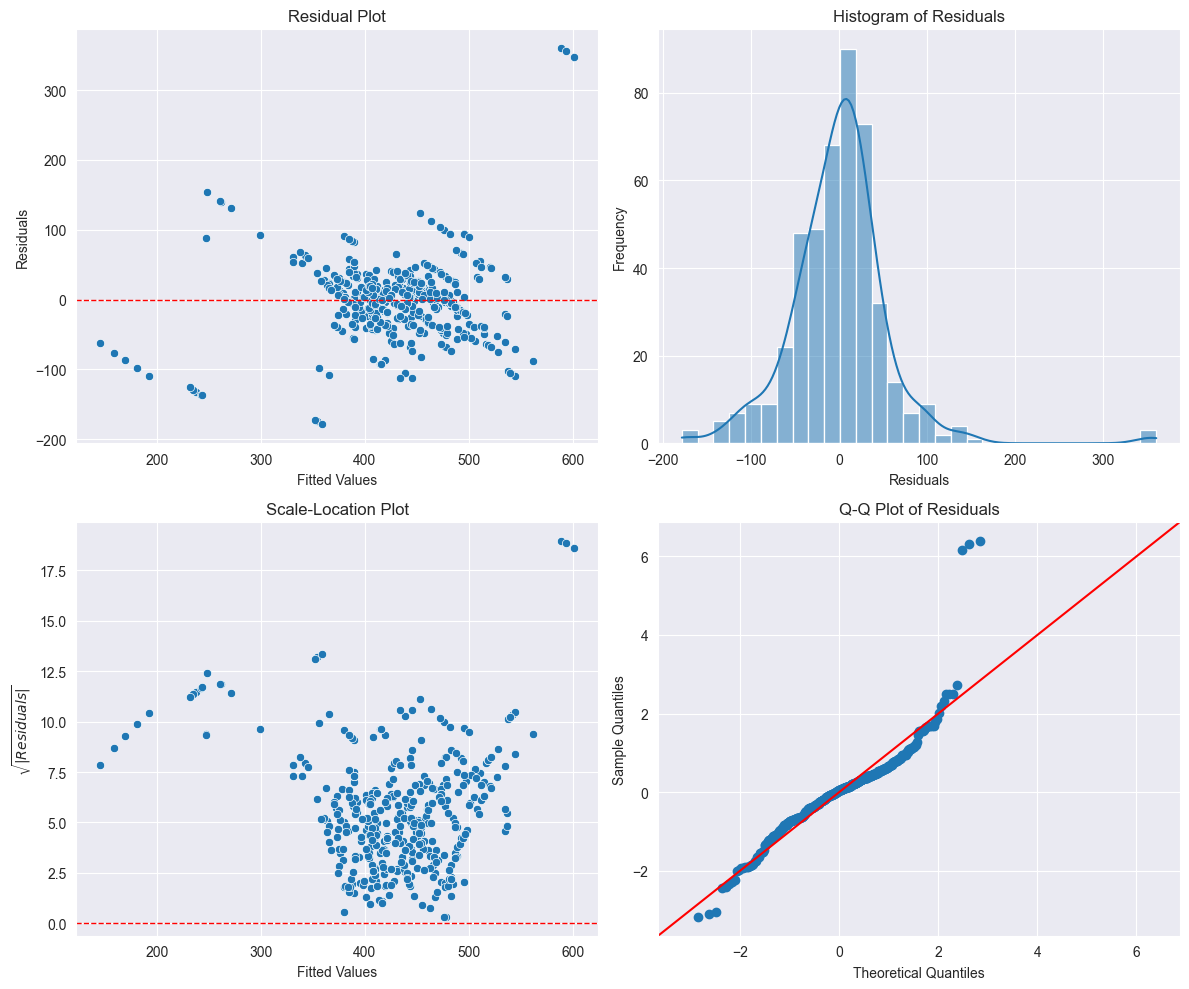

In [23]:
base_formula = "TST ~ 1"
test_terms = candidate_terms

best_model, model_count = backward_stepwise_selection(
    data=df_cleaned_for_TST,
    base_formula=base_formula,
    candidate_terms=test_terms,
    group_var="SID",
)

# Plot diagnostics for the best model
if best_model:
    plot_residual_diagnostics(best_model.fittedvalues, best_model.resid)

In [24]:
best_formula_no_interaction = best_model.model.formula
covariates = patsy.dmatrices(best_formula_no_interaction, df_cleaned_for_REM)[1].design_info.column_names
filtered_covariates = [var for var in covariates if var not in Hormone_columns and var not in Phase_terms]
interaction_terms_with_phases = [f"Phase:{var}" for var in filtered_covariates]

lrt_results_df = test_interaction_terms_lrt(
    base_model=best_model,  # The best model without interactions
    base_formula=best_formula_no_interaction,
    interaction_terms=interaction_terms_with_phases,
    data=df_cleaned_for_TST,
    group_var="SID"
)

# Sort by p-value to find significant interactions
lrt_results_df.sort_values(by="P-value", inplace=True)

print(lrt_results_df)

Error fitting model with interaction term Phase:Intercept: Error evaluating factor: NameError: name 'Intercept' is not defined
    TST ~ 1 + Negative_Mood_Index + Pain_PMS + Mean_Est + Mean_Prog + Mean_Testost + Overall_Alertness + Overall_Coordination + Phase + Phase:Intercept
                                                                                                                                              ^^^^^^^^^
Tested Interaction Term: Phase:Negative_Mood_Index
LRT Statistic: 4.276, DF: 3, P-value: 0.233, AIC: 5092.42
Tested Interaction Term: Phase:Pain_PMS
LRT Statistic: 7.557, DF: 3, P-value: 0.056, AIC: 5089.14
Tested Interaction Term: Phase:Overall_Alertness
LRT Statistic: 14.534, DF: 3, P-value: 0.002, AIC: 5082.17
Tested Interaction Term: Phase:Overall_Coordination
LRT Statistic: 13.438, DF: 3, P-value: 0.004, AIC: 5083.26
             Interaction Term  LRT Statistic  Degrees of Freedom   P-value  \
3     Phase:Overall_Alertness      14.534281                 3.0 

## Model for WASO

Backward step - Evaluating removal of term: Positive_Mood_Index, AIC: 3739.32
Backward step - Evaluating removal of term: Negative_Mood_Index, AIC: 3738.53
Backward step - Evaluating removal of term: Anger_Fru_Index, AIC: 3738.31
Backward step - Evaluating removal of term: Pain_PMS, AIC: 3738.68
Backward step - Evaluating removal of term: Bloating_PMS, AIC: 3738.25
Backward step - Evaluating removal of term: Bodyache_PMS, AIC: 3738.56
Backward step - Evaluating removal of term: Tenderness_PMS, AIC: 3739.07
Backward step - Evaluating removal of term: Caffine_Intake, AIC: 3738.39
Backward step - Evaluating removal of term: Alcohol_Intake, AIC: 3737.09
Backward step - Evaluating removal of term: Mean_Est, AIC: 3737.16
Backward step - Evaluating removal of term: Mean_Prog, AIC: 3759.40
Backward step - Evaluating removal of term: Mean_Testost, AIC: 3739.64
Backward step - Evaluating removal of term: Overall_Alertness, AIC: 3737.93
Backward step - Evaluating removal of term: Mental_Stamina, 

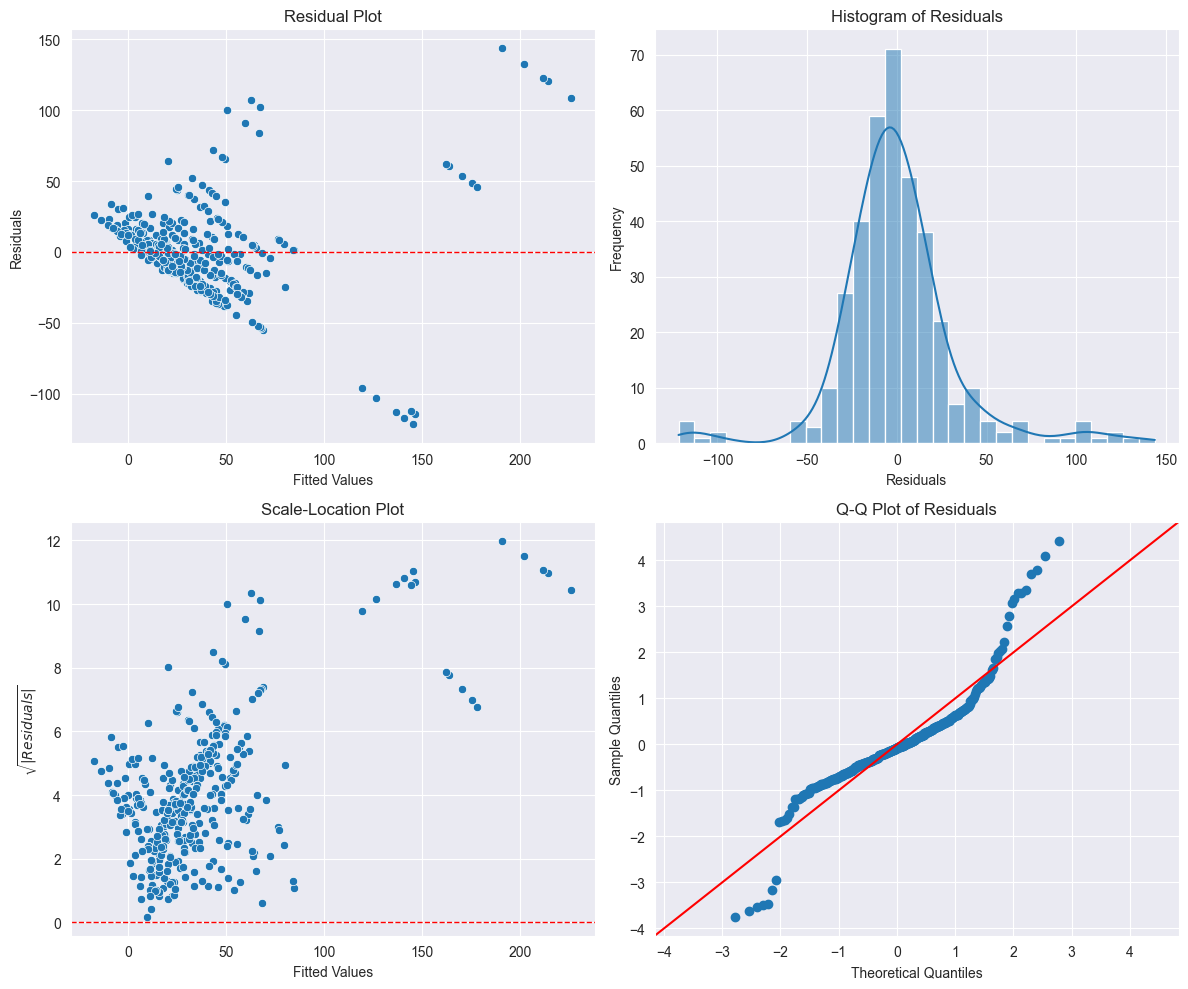

In [25]:
base_formula = "WASO ~ 1"
test_terms = candidate_terms

best_model, model_count = backward_stepwise_selection(
    data=df_cleaned_for_WASO,
    base_formula=base_formula,
    candidate_terms=test_terms,
    group_var="SID",
)

# Plot diagnostics for the best model
if best_model:
    plot_residual_diagnostics(best_model.fittedvalues, best_model.resid)

In [26]:
best_formula_no_interaction = best_model.model.formula
covariates = patsy.dmatrices(best_formula_no_interaction, df_cleaned_for_REM)[1].design_info.column_names
filtered_covariates = [var for var in covariates if var not in Hormone_columns and var not in Phase_terms]
interaction_terms_with_phases = [f"Phase:{var}" for var in filtered_covariates]

lrt_results_df = test_interaction_terms_lrt(
    base_model=best_model,  # The best model without interactions
    base_formula=best_formula_no_interaction,
    interaction_terms=interaction_terms_with_phases,
    data=df_cleaned_for_WASO,
    group_var="SID"
)

# Sort by p-value to find significant interactions
lrt_results_df.sort_values(by="P-value", inplace=True)

print(lrt_results_df)

Error fitting model with interaction term Phase:Intercept: Error evaluating factor: NameError: name 'Intercept' is not defined
    WASO ~ 1 + Positive_Mood_Index + Negative_Mood_Index + Tenderness_PMS + Mean_Prog + Mean_Testost + Thinking + Overall_Coordination + Phase + Phase:Intercept
                                                                                                                                                       ^^^^^^^^^
Tested Interaction Term: Phase:Positive_Mood_Index
LRT Statistic: 37.450, DF: 3, P-value: 0.000, AIC: 3690.15
Tested Interaction Term: Phase:Negative_Mood_Index
LRT Statistic: 21.186, DF: 3, P-value: 0.000, AIC: 3706.41
Tested Interaction Term: Phase:Tenderness_PMS
LRT Statistic: 17.807, DF: 3, P-value: 0.000, AIC: 3709.79
Tested Interaction Term: Phase:Thinking
LRT Statistic: 37.782, DF: 3, P-value: 0.000, AIC: 3689.82
Tested Interaction Term: Phase:Overall_Coordination
LRT Statistic: 42.417, DF: 3, P-value: 0.000, AIC: 3685.18
             Int

## Model for N1

Backward step - Evaluating removal of term: Positive_Mood_Index, AIC: 3225.32
Backward step - Evaluating removal of term: Negative_Mood_Index, AIC: 3225.33
Backward step - Evaluating removal of term: Anger_Fru_Index, AIC: 3225.46
Backward step - Evaluating removal of term: Pain_PMS, AIC: 3225.40
Backward step - Evaluating removal of term: Bloating_PMS, AIC: 3226.98
Backward step - Evaluating removal of term: Bodyache_PMS, AIC: 3225.56
Backward step - Evaluating removal of term: Tenderness_PMS, AIC: 3227.36
Backward step - Evaluating removal of term: Caffine_Intake, AIC: 3225.36
Backward step - Evaluating removal of term: Alcohol_Intake, AIC: 3227.17
Backward step - Evaluating removal of term: Mean_Est, AIC: 3229.69
Backward step - Evaluating removal of term: Mean_Prog, AIC: 3233.58
Backward step - Evaluating removal of term: Mean_Testost, AIC: 3225.48
Backward step - Evaluating removal of term: Overall_Alertness, AIC: 3227.29
Backward step - Evaluating removal of term: Mental_Stamina, 

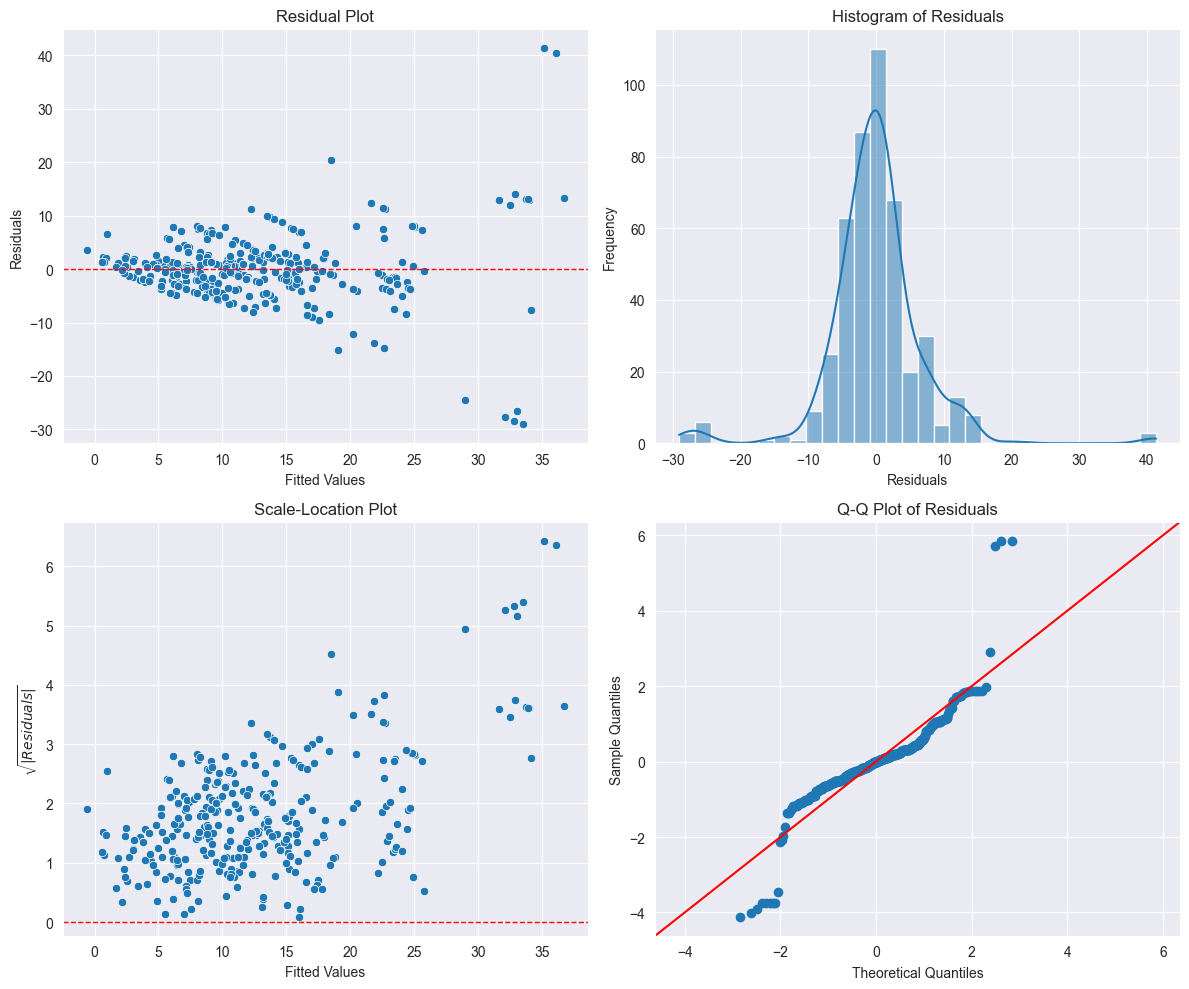

In [27]:
base_formula = "N1 ~ 1"
test_terms = candidate_terms

best_model, model_count = backward_stepwise_selection(
    data=df_cleaned_for_N1,
    base_formula=base_formula,
    candidate_terms=test_terms,
    group_var="SID",
)

# Plot diagnostics for the best model
if best_model:
    plot_residual_diagnostics(best_model.fittedvalues, best_model.resid)

In [28]:
best_formula_no_interaction = best_model.model.formula
covariates = patsy.dmatrices(best_formula_no_interaction, df_cleaned_for_REM)[1].design_info.column_names
filtered_covariates = [var for var in covariates if var not in Hormone_columns and var not in Phase_terms]
interaction_terms_with_phases = [f"Phase:{var}" for var in filtered_covariates]

lrt_results_df = test_interaction_terms_lrt(
    base_model=best_model,  # The best model without interactions
    base_formula=best_formula_no_interaction,
    interaction_terms=interaction_terms_with_phases,
    data=df_cleaned_for_N1,
    group_var="SID"
)

# Sort by p-value to find significant interactions
lrt_results_df.sort_values(by="P-value", inplace=True)

print(lrt_results_df)

Error fitting model with interaction term Phase:Intercept: Error evaluating factor: NameError: name 'Intercept' is not defined
    N1 ~ 1 + Tenderness_PMS + Mean_Est + Mean_Prog + Overall_Alertness + Social_Interactions + Phase + Phase:Intercept
                                                                                                             ^^^^^^^^^
Tested Interaction Term: Phase:Tenderness_PMS
LRT Statistic: 5.820, DF: 3, P-value: 0.121, AIC: 3202.27
Tested Interaction Term: Phase:Overall_Alertness
LRT Statistic: 12.138, DF: 3, P-value: 0.007, AIC: 3195.95
Tested Interaction Term: Phase:Social_Interactions
LRT Statistic: 8.806, DF: 3, P-value: 0.032, AIC: 3199.29
            Interaction Term  LRT Statistic  Degrees of Freedom   P-value  \
2    Phase:Overall_Alertness      12.138160                 3.0  0.006925   
3  Phase:Social_Interactions       8.806013                 3.0  0.031984   
1       Phase:Tenderness_PMS       5.820358                 3.0  0.120685   
0     

## Model for N2

Backward step - Evaluating removal of term: Positive_Mood_Index, AIC: 4807.61
Backward step - Evaluating removal of term: Negative_Mood_Index, AIC: 4804.58
Backward step - Evaluating removal of term: Anger_Fru_Index, AIC: 4803.25
Backward step - Evaluating removal of term: Pain_PMS, AIC: 4805.88
Backward step - Evaluating removal of term: Bloating_PMS, AIC: 4803.87
Backward step - Evaluating removal of term: Bodyache_PMS, AIC: 4804.63
Backward step - Evaluating removal of term: Tenderness_PMS, AIC: 4803.86
Backward step - Evaluating removal of term: Caffine_Intake, AIC: 4803.63
Backward step - Evaluating removal of term: Alcohol_Intake, AIC: 4805.27
Backward step - Evaluating removal of term: Mean_Est, AIC: 4805.30
Backward step - Evaluating removal of term: Mean_Prog, AIC: 4814.16
Backward step - Evaluating removal of term: Mean_Testost, AIC: 4810.14
Backward step - Evaluating removal of term: Overall_Alertness, AIC: 4804.28
Backward step - Evaluating removal of term: Mental_Stamina, 

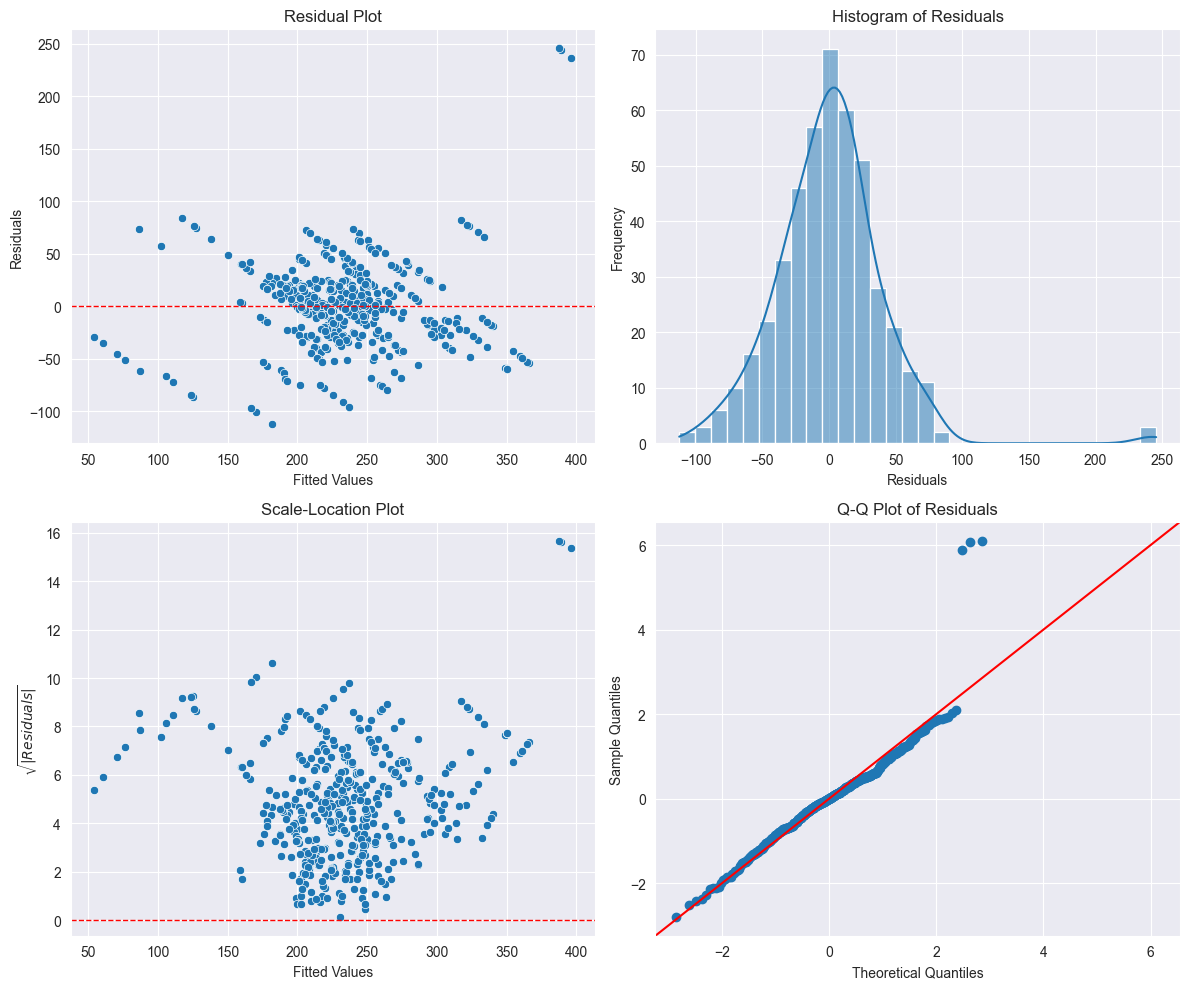

In [29]:
base_formula = "N2 ~ 1"
test_terms = candidate_terms

best_model, model_count = backward_stepwise_selection(
    data=df_cleaned_for_N2,
    base_formula=base_formula,
    candidate_terms=test_terms,
    group_var="SID",
)

# Plot diagnostics for the best model
if best_model:
    plot_residual_diagnostics(best_model.fittedvalues, best_model.resid)

In [30]:
best_formula_no_interaction = best_model.model.formula
covariates = patsy.dmatrices(best_formula_no_interaction, df_cleaned_for_REM)[1].design_info.column_names
filtered_covariates = [var for var in covariates if var not in Hormone_columns and var not in Phase_terms]
interaction_terms_with_phases = [f"Phase:{var}" for var in filtered_covariates]

lrt_results_df = test_interaction_terms_lrt(
    base_model=best_model,  # The best model without interactions
    base_formula=best_formula_no_interaction,
    interaction_terms=interaction_terms_with_phases,
    data=df_cleaned_for_N2,
    group_var="SID"
)

# Sort by p-value to find significant interactions
lrt_results_df.sort_values(by="P-value", inplace=True)

print(lrt_results_df)

Error fitting model with interaction term Phase:Intercept: Error evaluating factor: NameError: name 'Intercept' is not defined
    N2 ~ 1 + Positive_Mood_Index + Bodyache_PMS + Alcohol_Intake + Mean_Prog + Mean_Testost + Mood_Stability + Social_Interactions + Phase + Phase:Intercept
                                                                                                                                                   ^^^^^^^^^
Tested Interaction Term: Phase:Positive_Mood_Index
LRT Statistic: 7.043, DF: 3, P-value: 0.071, AIC: 4790.26
Tested Interaction Term: Phase:Bodyache_PMS
LRT Statistic: 9.385, DF: 3, P-value: 0.025, AIC: 4787.92
Tested Interaction Term: Phase:Alcohol_Intake
LRT Statistic: 1.019, DF: 3, P-value: 0.797, AIC: 4796.29
Tested Interaction Term: Phase:Mood_Stability
LRT Statistic: 3.359, DF: 3, P-value: 0.340, AIC: 4793.95
Tested Interaction Term: Phase:Social_Interactions
LRT Statistic: 7.296, DF: 3, P-value: 0.063, AIC: 4790.01
            Interaction Term  L

## Model for SWS

Backward step - Evaluating removal of term: Positive_Mood_Index, AIC: 4039.94
Backward step - Evaluating removal of term: Negative_Mood_Index, AIC: 4040.46
Backward step - Evaluating removal of term: Anger_Fru_Index, AIC: 4043.89
Backward step - Evaluating removal of term: Pain_PMS, AIC: 4041.95
Backward step - Evaluating removal of term: Bloating_PMS, AIC: 4040.72
Backward step - Evaluating removal of term: Bodyache_PMS, AIC: 4040.83
Backward step - Evaluating removal of term: Tenderness_PMS, AIC: 4040.63
Backward step - Evaluating removal of term: Caffine_Intake, AIC: 4039.68
Backward step - Evaluating removal of term: Alcohol_Intake, AIC: 4042.42
Backward step - Evaluating removal of term: Mean_Est, AIC: 4040.65
Backward step - Evaluating removal of term: Mean_Prog, AIC: 4040.32
Backward step - Evaluating removal of term: Mean_Testost, AIC: 4048.97
Backward step - Evaluating removal of term: Overall_Alertness, AIC: 4039.79
Backward step - Evaluating removal of term: Mental_Stamina, 

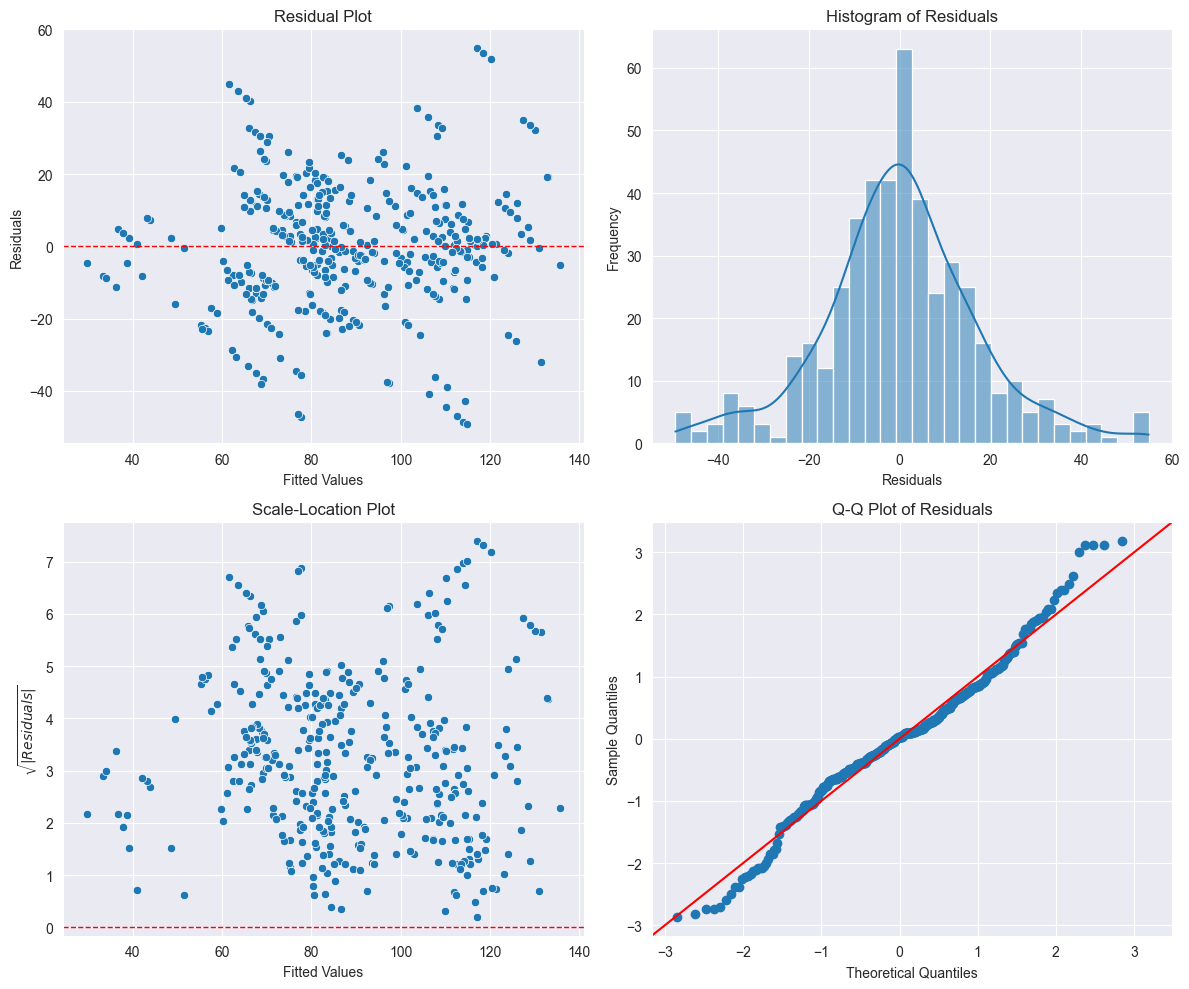

In [31]:
base_formula = "SWS ~ 1"
test_terms = candidate_terms

best_model, model_count = backward_stepwise_selection(
    data=df_cleaned_for_SWS,
    base_formula=base_formula,
    candidate_terms=test_terms,
    group_var="SID",
)

# Plot diagnostics for the best model
if best_model:
    plot_residual_diagnostics(best_model.fittedvalues, best_model.resid)

In [32]:
best_formula_no_interaction = best_model.model.formula
covariates = patsy.dmatrices(best_formula_no_interaction, df_cleaned_for_REM)[1].design_info.column_names
filtered_covariates = [var for var in covariates if var not in Hormone_columns and var not in Phase_terms]
interaction_terms_with_phases = [f"Phase:{var}" for var in filtered_covariates]

lrt_results_df = test_interaction_terms_lrt(
    base_model=best_model,  # The best model without interactions
    base_formula=best_formula_no_interaction,
    interaction_terms=interaction_terms_with_phases,
    data=df_cleaned_for_SWS,
    group_var="SID"
)

# Sort by p-value to find significant interactions
lrt_results_df.sort_values(by="P-value", inplace=True)

print(lrt_results_df)

Error fitting model with interaction term Phase:Intercept: Error evaluating factor: NameError: name 'Intercept' is not defined
    SWS ~ 1 + Anger_Fru_Index + Pain_PMS + Alcohol_Intake + Mean_Prog + Mean_Testost + Social_Interactions + Phase:Intercept
                                                                                                                   ^^^^^^^^^
Tested Interaction Term: Phase:Anger_Fru_Index
LRT Statistic: 3.671, DF: 3, P-value: 0.299, AIC: 4023.25
Tested Interaction Term: Phase:Pain_PMS
LRT Statistic: 4.621, DF: 3, P-value: 0.202, AIC: 4022.30
Tested Interaction Term: Phase:Alcohol_Intake
LRT Statistic: 2.327, DF: 3, P-value: 0.507, AIC: 4024.60
Tested Interaction Term: Phase:Social_Interactions
LRT Statistic: 5.895, DF: 3, P-value: 0.117, AIC: 4021.03
            Interaction Term  LRT Statistic  Degrees of Freedom   P-value  \
4  Phase:Social_Interactions       5.895356                 3.0  0.116814   
2             Phase:Pain_PMS       4.620655          

## Model for NREM

Backward step - Evaluating removal of term: Positive_Mood_Index, AIC: 4913.71
Backward step - Evaluating removal of term: Negative_Mood_Index, AIC: 4913.49
Backward step - Evaluating removal of term: Anger_Fru_Index, AIC: 4912.28
Backward step - Evaluating removal of term: Pain_PMS, AIC: 4915.55
Backward step - Evaluating removal of term: Bloating_PMS, AIC: 4912.66
Backward step - Evaluating removal of term: Bodyache_PMS, AIC: 4913.62
Backward step - Evaluating removal of term: Tenderness_PMS, AIC: 4911.38
Backward step - Evaluating removal of term: Caffine_Intake, AIC: 4912.03
Backward step - Evaluating removal of term: Alcohol_Intake, AIC: 4911.65
Backward step - Evaluating removal of term: Mean_Est, AIC: 4914.25
Backward step - Evaluating removal of term: Mean_Prog, AIC: 4922.22
Backward step - Evaluating removal of term: Mean_Testost, AIC: 4923.20
Backward step - Evaluating removal of term: Overall_Alertness, AIC: 4912.69
Backward step - Evaluating removal of term: Mental_Stamina, 

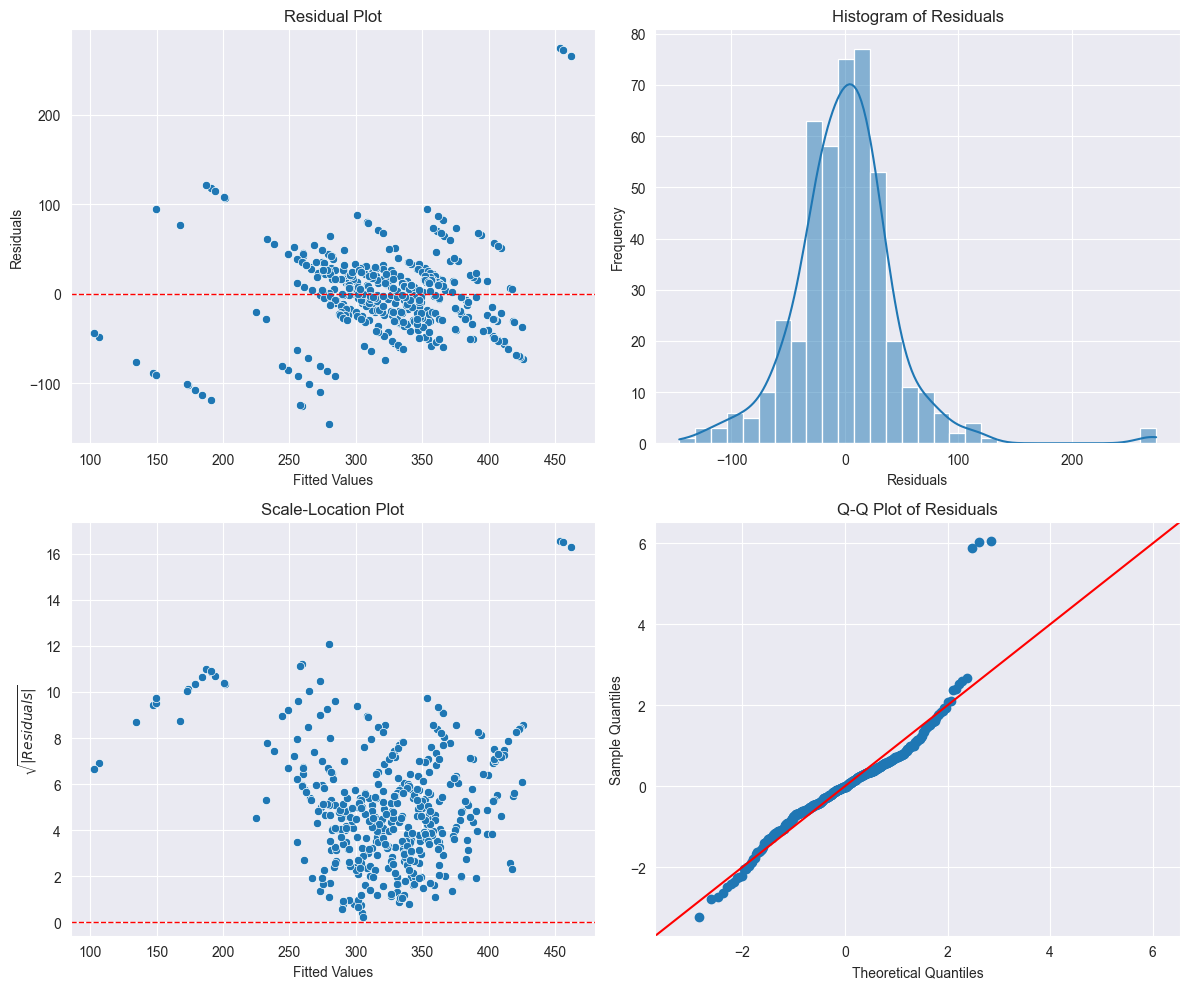

In [33]:
base_formula = "NREM ~ 1"
test_terms = candidate_terms

best_model, model_count = backward_stepwise_selection(
    data=df_cleaned_for_NREM,
    base_formula=base_formula,
    candidate_terms=test_terms,
    group_var="SID",
)

# Plot diagnostics for the best model
if best_model:
    plot_residual_diagnostics(best_model.fittedvalues, best_model.resid)

In [34]:
best_formula_no_interaction = best_model.model.formula
covariates = patsy.dmatrices(best_formula_no_interaction, df_cleaned_for_REM)[1].design_info.column_names
filtered_covariates = [var for var in covariates if var not in Hormone_columns and var not in Phase_terms]
interaction_terms_with_phases = [f"Phase:{var}" for var in filtered_covariates]

lrt_results_df = test_interaction_terms_lrt(
    base_model=best_model,  # The best model without interactions
    base_formula=best_formula_no_interaction,
    interaction_terms=interaction_terms_with_phases,
    data=df_cleaned_for_NREM,
    group_var="SID"
)

# Sort by p-value to find significant interactions
lrt_results_df.sort_values(by="P-value", inplace=True)

print(lrt_results_df)

Error fitting model with interaction term Phase:Intercept: Error evaluating factor: NameError: name 'Intercept' is not defined
    NREM ~ 1 + Positive_Mood_Index + Negative_Mood_Index + Pain_PMS + Bodyache_PMS + Mean_Est + Mean_Prog + Mean_Testost + Mood_Stability + Social_Interactions + Phase + Phase:Intercept
                                                                                                                                                                                ^^^^^^^^^
Tested Interaction Term: Phase:Positive_Mood_Index
LRT Statistic: 17.737, DF: 3, P-value: 0.000, AIC: 4886.30
Tested Interaction Term: Phase:Negative_Mood_Index
LRT Statistic: 5.839, DF: 3, P-value: 0.120, AIC: 4898.20
Tested Interaction Term: Phase:Pain_PMS
LRT Statistic: 5.631, DF: 3, P-value: 0.131, AIC: 4898.40
Tested Interaction Term: Phase:Bodyache_PMS
LRT Statistic: 8.638, DF: 3, P-value: 0.035, AIC: 4895.40
Tested Interaction Term: Phase:Mood_Stability
LRT Statistic: 4.976, DF: 3, P-value